In [1]:
import torch
import nvdiffrast.torch as dr
import torch.nn.functional as F
import os
from pathlib import Path, PosixPath
import sys
sys.path.insert(0, str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
from utils.args import Args
import tinyplypy
import numpy as np
from data import loader
import math
import matplotlib.pyplot as plt

args = Args()
args.tile_size = 16
args.image_folder = "images_4"
args.eval = False
args.dataset_path = Path("/data/nerf_datasets/360/bonsai")
# args.dataset_path = Path("/data/nerf_datasets/360/garden")
# args.output_path = Path("output/test/")
# args.mesh_path = Path("/home/amai/delaunay_splatting/output/i30000_ld1.00E-04/meshes/3.ply")
# args.output_path = Path("/home/amai/delaunay_splatting/output/i30000_ld1.00E-04/")
args.output_path = Path("/home/amai/delaunay_splatting/output/garden_ifimages_4_r33_noglo_distscale_wd0.1_dTmulT0.1_ld1e-5")
args.output_path = Path("/home/amai/delaunay_splatting/output/i30000_ld1.00E-03")
args.data_device = 'cpu'
args.iterations = 5000

pca_transform = torch.as_tensor(np.loadtxt(args.output_path / "transform.txt")).cuda().float()

train_cameras, test_cameras, scene_info = loader.load_dataset(
    args.dataset_path, args.image_folder, data_device=args.data_device, eval=args.eval, orient_scene=True)



def load_all_meshes(meshes_dir, device="cuda", dtype=torch.float32):
    meshes_dir = Path(meshes_dir)
    ply_paths = sorted(meshes_dir.glob("*.ply"))
    if not ply_paths:
        raise FileNotFoundError(f"No .ply files found in {meshes_dir}")

    all_verts, all_colors, all_faces = [], [], []
    vert_offset = 0

    for p in ply_paths:
        m = tinyplypy.read_ply(str(p))

        # verts
        v = np.stack([m["vertex"]["x"], m["vertex"]["y"], m["vertex"]["z"]], axis=-1).astype(np.float32)

        # colors (fallback to white if missing)
        if all(k in m["vertex"] for k in ("r", "g", "b")):
            c = np.stack([m["vertex"]["r"], m["vertex"]["g"], m["vertex"]["b"]], axis=-1)
            c = c.astype(np.float32)
        else:
            c = np.full((v.shape[0], 3), 255.0, dtype=np.float32)  # white

        # faces (ensure Nx3 and offset indices)
        f = np.asarray(m["face"]["vertex_indices"], dtype=np.int64)
        if f.ndim != 2 or f.shape[1] != 3:
            f = np.stack(f, axis=0)  # handle jagged/list-of-lists case
        f = f + vert_offset

        all_verts.append(v)
        all_colors.append(c)
        all_faces.append(f)
        vert_offset += v.shape[0]

    verts = torch.tensor(np.concatenate(all_verts, axis=0), device=device, dtype=dtype)
    v_rgb = torch.tensor(np.concatenate(all_colors, axis=0), device=device, dtype=torch.float32)
    faces = torch.tensor(np.concatenate(all_faces, axis=0), device=device, dtype=torch.int32)

    return verts, v_rgb, faces

/home/amai/delaunay_splatting
Reading camera 292/292


Loading cameras: 100%|██████████| 292/292 [00:02<00:00, 142.92it/s]


CameraInfo(uid=1, R=array([[ 0.45692053, -0.23930623,  0.85671241],
       [ 0.63926841,  0.75805208, -0.12920121],
       [-0.61851397,  0.60670386,  0.49935047]]), T=array([ 0.25063347, -2.21530033,  3.59113953]), fovy=0.62375764619403, fovx=0.9011358354744409, cx=1559.0, cy=1039.0, image=None, image_path='/data/nerf_datasets/360/bonsai/images_4/DSCF5565.JPG', image_name='DSCF5565', width=3118, height=2078, model=<ProjectionType.PERSPECTIVE: 0>, distortion_params=array([0., 0., 0., 0.]), exposure=1, iso=100, aperature=1)
Loaded Train Cameras: 292


Loading cameras: 0it [00:00, ?it/s]

Loaded Test Cameras: 0
Transforming poses


In [2]:
verts, v_rgb, faces = load_all_meshes(args.output_path/"meshes", device="cuda")

/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


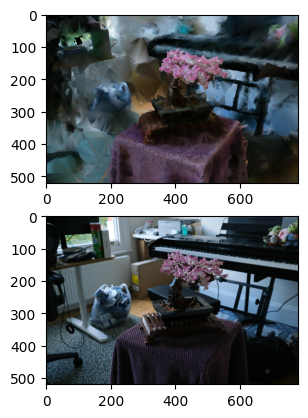

Step 0, loss: 0.1110, PSNR: 0.00 dB


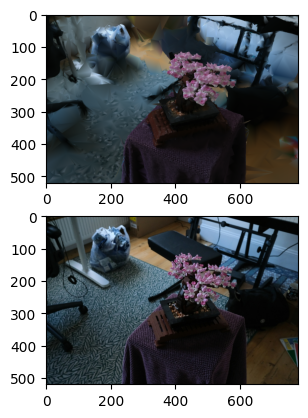

Step 1000, loss: 0.0534, PSNR: 21.08 dB


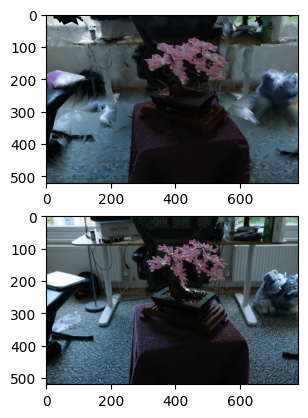

Step 2000, loss: 0.0629, PSNR: 21.13 dB


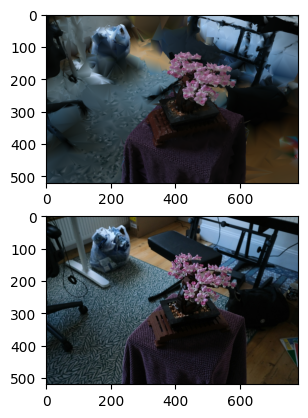

Step 3000, loss: 0.0521, PSNR: 21.16 dB


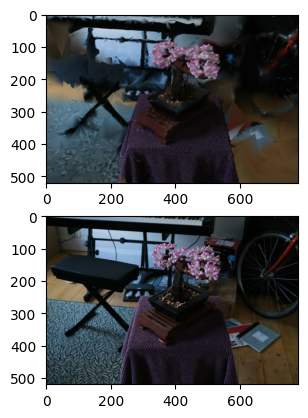

Step 4000, loss: 0.0531, PSNR: 21.19 dB


In [3]:
import random

def perspective2(fx, fy, cx, cy, W, H, znear=0.01, zfar=100.0):
    P = torch.zeros((4,4), device="cuda", dtype=torch.float32)
    P[0,0] =  2.0*fx / W
    P[1,1] =  2.0*fy / H
    P[0,2] =  1.0 - 2.0*cx / W
    P[1,2] =  2.0*cy / H - 1.0
    P[2,2] =  (zfar + znear) / (znear - zfar)
    P[2,3] =  2.0*zfar*znear / (znear - zfar)
    P[3,2] = -1.0
    return P

def perspective(fovx=0.7854, fovy=0.7854, n=0.1, f=1000.0, device=None):
    x = np.tan(fovx / 2)
    y = np.tan(fovy / 2)
    return torch.tensor([[1/x,    0,            0,              0], 
                         [           0, 1/-y,            0,              0], 
                         [           0,    0, -(f+n)/(f-n), -(2*f*n)/(f-n)], 
                         [           0,    0,           -1,              0]], dtype=torch.float32, device=device)

def render_one(v_rgb_p, camera, W, H, bg=1.0):
    view = camera.world_view_transform.cuda().T
    proj = camera.projection_matrix.T.cuda()

    V = torch.cat([verts, torch.ones_like(verts[:, :1])], dim=1)
    full = proj @ view
    pos = (V @ full.T).unsqueeze(0).contiguous()

    rast, rast_db = dr.rasterize(glctx, pos, faces, (H, W), grad_db=True)  # [1,H,W,4]
    rgb, _ = dr.interpolate(torch.sigmoid(v_rgb_p[None]).contiguous(), rast, faces, rast_db=rast_db)  # [1,H,W,3]  (broadcast)
    rgb_aa = dr.antialias(rgb, rast, pos, faces)  # pos is [1,V,4]
    im = rgb_aa[0].permute(2, 0, 1)
    return im, rast

def inverse_sigmoid(x):
    return torch.log(x / (1.0 - x))
# --- Training loop sketch ---
# optim = torch.optim.Adam([verts, v_rgb], lr=1e-4)
verts = torch.nn.Parameter(verts)       # (V,3)
v_rgb_p = torch.nn.Parameter(inverse_sigmoid(v_rgb.clip(min=1e-3, max=0.99)))       # (V,3)
glctx = dr.RasterizeCudaContext()
optim = torch.optim.Adam([
    {"params": [v_rgb_p],  "lr": 1e-2,  "name": "rgb"},
    {"params": [verts],  "lr": 1e-6,  "name": "verts"},
])
inds = []
psnrs = [[]]

for step in range(args.iterations):

    if len(inds) == 0:
        psnrs.append([])
        inds = list(range(len(train_cameras)))
        random.shuffle(inds)
    ind = inds.pop()
    camera = train_cameras[ind]
    target = camera.original_image.cuda()  # (H,W,3), range [0,1]
    H, W = target.shape[1:3]

    pred, rast = render_one(v_rgb_p, camera, W, H)  # note nvdiffrast uses (H,W)
    loss = F.l1_loss(pred, target)
    if step % 1000 == 0:
        fig, axs = plt.subplots(2)
        axs[0].imshow(pred.detach().permute(1, 2, 0).cpu().numpy())
        axs[1].imshow(target.detach().permute(1, 2, 0).cpu().numpy())
        plt.show()
        disp_ind = max(len(psnrs)-2, 0)
        avg_psnr = sum(psnrs[disp_ind]) / max(len(psnrs[disp_ind]), 1)
        print(f"Step {step}, loss: {F.l1_loss(pred, target).item():.4f}, PSNR: {avg_psnr:.2f} dB")
        # print([np.mean(p) for p in psnrs if len(p) == len(train_cameras)])

    # If your target is top-down, flip to match nvdiffrast's bottom-up, or flip pred instead
    # target = torch.flip(target, dims=[0])  # uncomment if needed  ← see docs
    l2_loss = ((target - pred)**2).mean()
    psnr = 20 * math.log10(1.0 / math.sqrt(l2_loss.detach().cpu().item()))
    psnrs[-1].append(psnr)

    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()


In [4]:
verts_np = verts.detach().cpu().numpy()
v_rgb_np = v_rgb.detach().cpu().numpy()
tinyplypy.write_ply(str(args.output_path / "mesh.ply"), dict(
    vertex=dict(
        x=verts_np[:, 0].astype(np.float32),
        y=verts_np[:, 1].astype(np.float32),
        z=verts_np[:, 2].astype(np.float32),
        r=v_rgb_np[:, 0].astype(np.float32),
        g=v_rgb_np[:, 1].astype(np.float32),
        b=v_rgb_np[:, 2].astype(np.float32),
    ),
    face=dict(
        vertex_indices=faces.cpu().numpy().reshape(-1, 3).astype(np.int32)
    )
))